### Предпосылки и причины ускорения A/B тестов

Основная предпосылка для ускорения A/B-тестов — это стремление к **повышению их чувствительности**. Повышение чувствительности теста означает, что при фиксированных вероятностях ошибок он способен обнаруживать эффекты меньшего размера или требует меньший объем данных.

Причины для ускорения A/B-тестов включают:
*   **Увеличение скорости тестирования гипотез**. Чем быстрее завершается тест, тем больше гипотез можно проверить за определенный промежуток времени, что способствует более быстрому развитию продукта.
*   **Сокращение времени ожидания**. Менеджеры часто хотят получать результаты как можно быстрее, а длительные тесты (иногда до 200-400 недель) вызывают недовольство и задерживают принятие решений. Ускорение позволяет уменьшить "очередь" тестов и освободить слоты для новых экспериментов.
*   **Экономия на данных**. Чувствительные тесты требуют меньшего количества наблюдений, что экономит ресурсы.
*   **Выявление малых эффектов**. Маленькие изменения, которые трудно заметить, со временем могут складываться в большие улучшения, принося значительную прибыль. Повышенная чувствительность позволяет обнаруживать такие эффекты.
*   **Минимизация негативного влияния**. Если изменение имеет отрицательный эффект, проведение теста на меньшей выборке пользователей снижает потенциальные потери.

### Методы ускорения A/B-тестов

У всякого A/B теста есть обязательные составляющие, и самым простым и очевидным (но не всегда возможным) способом ускорить тестирование будет их подкрутка:

<br></br>

|№|Составляющая|Что можно сделать|
|---|---|---|
|1. |Формализация гипотезы |Уточненить гипотезу, чтобы уменьшить количество метрик для проверки. Это, в свою, очередь, поднимет мощность теста, что позволит выбрать менее мощный, но более экономный критерий.|
|2. | Количество тестовых групп | Увеличить количество тестируемых групп, чтобы покрыть разные сценарии фичи. Таким образом можно будет обойтись 1 тестом, вместо N.|
|3. | Метрики для принятия решений | Выбрать более чувствительные метрики, которые можно прокрасить быстрее.|
|4. |Ошибки 1 и 2 рода |Согласиться на более высокие значения ошибок 1 и 2 рода, что снизит необходимый размер выборки и позволит сократить время проведения теста.|
|5. | Статистический критерий| Подобрать наиболее мощный критерий, контролирующий ошибку 1 рода на обговорённом уровне. Чем оптимальнее критерий, тем меньше можно держать эксперимент.|
|6. | Минимально детектируемый эффект (MDE)| Принять, что для подтверждении гипотезы достаточно и большего эффекта. Тогда поднимаем MDE, что напрямую сокращает длительность теста.|
|7.| Дизайн эксперимента| Использовать последовательные тесты (Sequential Testing) вместо fixed-horizon, чтобы принятие решений происходило быстрее.|

Если все составляющие уже обговорены и не подлежат изменениям, то придётся что-то придумывать по-хитрее. По сути длительность теста напрямую зависит от необходимого размера выборки. Давайте вспомни, как она считается:

$$
N = \frac{\left( \Phi^{-1}_{(1 - \alpha/2)} + \Phi^{-1}_{(1-\beta)} \right)^2 \times 2 \sigma^2}{MDE^2}
$$


Получается, что у нас осталось ещё дисперсия, на которую мы можем повлиять. На деле есть несколько подходов, как можно её уменьшить  

#### Методы уменьшения дисперсии

##### [Очистка данных от выбросов](https://habr.com/ru/companies/avito/articles/571094/#:~:text=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%D1%8B%20%D0%B1%D0%BE%D1%80%D1%8C%D0%B1%D1%8B%20%D1%81%20%D0%B2%D1%8B%D0%B1%D1%80%D0%BE%D1%81%D0%B0%D0%BC%D0%B8%20%D0%B2%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)

Не секрет, что чем больше у вас выбросов, тем больше будет дисперсия в данных. А отсюда уже следует, что у вас будет менее мощный критерий. Поэтому иногда аналитикам приходит в голову **убрать топ n% пользователей с минимальной (максимальной) метрикой в тесте и контроле.**

Идея вполне здравая, но к ней нужно подходить осторожно, так как

1. неправильная реализация может только исказить истиные результаты экперимента;
2. выкидывая топ юзеров из рассмотрения и принимая решение о раскатке теста на основе оставшихся пользователей, вы автоматически считаете, что топ юзеров поведёт себя также, как и остальные пользователи, или лучше. Что на самом деле может быть не так. Это стоит всегда стоит дополнительно проверять;

###### Функция

In [ ]:
import math
import time
from collections import defaultdict
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportion_confint
from tqdm import tqdm


In [ ]:
CUTOFF_CONFIG = {
    "n_simulations": 10_000,
    "sample_size": 1_000,
    "true_mean": 1_000.0,
    "cutoff_percent": 1.0,  # доля хвоста в процентах
}


def absolute_ttest(control: np.ndarray, test: np.ndarray) -> tuple[float, float, float, float]:
    """Вычисляет t-тест для двух независимых выборок и 95% ДИ разницы средних."""
    delta = float(np.mean(test) - np.mean(control))
    _, p_value = stats.ttest_ind(control, test, equal_var=False)

    se = float(np.sqrt(np.var(control, ddof=1) / len(control) + np.var(test, ddof=1) / len(test)))
    z_score = stats.norm.ppf(0.975)
    ci_low = delta - z_score * se
    ci_high = delta + z_score * se

    return delta, float(p_value), float(ci_low), float(ci_high)


def simulate_cutoff_problem(
    n_simulations: int,
    sample_size: int,
    true_mean: float,
    cutoff_percent: float,
    true_cutoff: Optional[float] = None,
    show_plots: bool = True,
) -> dict[str, float]:
    """Моделирует обрезку хвоста распределения и оценивает ошибку I рода."""
    false_positives = 0
    cutoff_diffs: list[float] = []
    sample_size_diffs: list[int] = []
    effects: list[float] = []

    cutoff_fraction = cutoff_percent / 100
    target_cutoff = (
        true_cutoff
        if true_cutoff is not None
        else stats.expon(scale=true_mean).ppf(1 - cutoff_fraction)
    )

    for _ in tqdm(range(n_simulations), desc="Running simulations"):
        control = stats.expon(scale=true_mean).rvs(sample_size)
        test = stats.expon(scale=true_mean).rvs(sample_size)

        if true_cutoff is None:
            q_control = float(np.quantile(control, 1 - cutoff_fraction))
            q_test = float(np.quantile(test, 1 - cutoff_fraction))
        else:
            q_control = q_test = float(target_cutoff)

        control_filtered = control[control <= q_control]
        test_filtered = test[test <= q_test]

        cutoff_diffs.append(abs(q_control - q_test))
        sample_size_diffs.append(abs(len(control_filtered) - len(test_filtered)))

        delta, _, ci_low, ci_high = absolute_ttest(control_filtered, test_filtered)
        effects.append(delta)

        if ci_low > 0 or ci_high < 0:
            false_positives += 1

    alpha_est = false_positives / n_simulations
    alpha_ci_low, alpha_ci_high = proportion_confint(false_positives, n_simulations, method="wilson")

    print(f"\nОбрезка верхних {cutoff_percent}%:")
    print(f"Целевое значение отсечки: {target_cutoff:.1f}")
    print(
        f"Среднее расхождение по отсечке: "
        f"{np.mean([target_cutoff - x for x in cutoff_diffs]):.1f} ± {np.std(cutoff_diffs):.1f}"
    )
    print(f"Разница в размере выборок: {np.mean(sample_size_diffs):.1f} ± {np.std(sample_size_diffs):.1f}")
    print(f"Оценка эффекта (ожидаем 0): {np.mean(effects):.2f} ± {np.std(effects):.2f}")
    print(f"\nОценка ошибки I рода: {alpha_est:.4f}")
    print(f"95% ДИ: [{alpha_ci_low:.4f}, {alpha_ci_high:.4f}]")

    if show_plots:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.hist(cutoff_diffs, bins=50, color="skyblue")
        plt.title(f"Разница в выбранной отсечке\n({cutoff_percent}% квантиль)")
        plt.xlabel("Разница квантилей")

        plt.subplot(1, 3, 2)
        plt.hist(sample_size_diffs, bins=50, color="salmon")
        plt.title("Разница в размерах выборок")
        plt.xlabel("Количество наблюдений")

        plt.subplot(1, 3, 3)
        plt.hist(effects, bins=100, color="lightgreen", range=(-true_mean * 0.1, true_mean * 0.1))
        plt.title("Распределение оценок эффекта")
        plt.xlabel("Эффект")
        plt.axvline(0, color="red", linestyle="--")

        plt.tight_layout()
        plt.show()

    return {
        "alpha_estimate": float(alpha_est),
        "alpha_ci": (float(alpha_ci_low), float(alpha_ci_high)),
        "mean_effect": float(np.mean(effects)),
    }


###### **Нельзя** чистить данные по факту эксперимента на основе контрольной и тестовой группы

In [ ]:
simulate_cutoff_problem(
    **CUTOFF_CONFIG,
    true_cutoff=None,
    show_plots=True,
)


Мы получили, что в таком случае процент ошибок первого рода не 5%, как мы ожидали, а 7.4%. Это значит, что метод некорректен и его нельзя использовать.

Почему так произошло? Дело в том, что мы не знаем точного значения 0.99 квантили, а лишь её оценку. Без точного значения у нас получаются разные пороги в тесте и в контроле, а значит, и разные итоговые выборки. К примеру, в одной выборке все значения будут меньше 2000, а в другой — меньше 3000, потому что из-за шума получились разные оценки квантили.

###### 2. **Рекоммендуется использовать общий квнатиль для отчесения значений**

Чтобы исправить недостаток, можно брать один квантиль для теста и контроля. В таком случае значение квантиля нельзя считать на всём тесте или на всём контроле или на объединенной выборке теста и контроля. Проблема состоит в том, что тест и контроль отличаются друг от друга влиянием тритмента. Поэтому, если средние в тесте и в контроле отличаются, то использование общего квантиля для отсечения в обоих выборках приведёт к тому, что мы выкинем из теста больше значений. В худшем случае мы будем сравнивать среднее без 1% в тесте со средним на всей выборке в контроле, что совсем не то, что мы хотим.

В таком случае предлагается подобрать порог отсечения, используя значение целевой метрики на предпериоде. К примеру, отсечь топ 1% юзеров по выручке за 2 месяца до эксперимента, когда никакого тритмента не было в тесте.

In [ ]:
known_cutoff = stats.expon(scale=CUTOFF_CONFIG["true_mean"]).ppf(
    1 - CUTOFF_CONFIG["cutoff_percent"] / 100
)

simulate_cutoff_problem(
    **CUTOFF_CONFIG,
    true_cutoff=known_cutoff,
    show_plots=True,
)


##### [Стратификация](https://habr.com/ru/companies/X5Tech/articles/596279/)

Стратификация позволяет снизить дисперсию метрик засчёт использования дополнительной информации в подсчёте метрик.

Для понимания стратификации введем несколько ключевых определений:
*   **Популяция** – это все пользователи (или объекты), на которых мы можем повлиять нашим экспериментом. Например, 10 тысяч активных пользователей интернет-магазина.
*   **Ковариата** – это метрика, которая:
    *   коррелирует с целевой метрикой.
    *   может быть измерена до начала эксперимента.
    *   не зависит от воздействия эксперимента.
    
    Примеры ковариат для экспериментов с людьми включают пол, возраст, город проживания, операционную систему. Для магазинов это могут быть размер торговой площади или режим работы.
*   **Страты** – это непересекающиеся подмножества популяции, которые обладают уникальным набором значений ковариат.

Дисперсия обычного среднего при случайном семплировании может быть представлена в виде суммы дисперсий *внутри* стратифицированных групп и *между* стратифицированными группами. Стратификация эффективно **убирает часть дисперсии, которая объясняется различиями между стратами**, что приводит к общему снижению дисперсии метрики.

Существует два основных подхода к реализации стратификации:

###### Функции

In [ ]:
@dataclass
class StratifiedABConfig:
    alpha: float = 0.05
    beta: float = 0.2
    mu_control: float = 2500.0
    effect: float = 100.0
    std: float = 800.0
    w_one: float = 0.5
    w_two: float = 0.5
    population_size: int = 10_000
    sample_size: int = 1_100
    mu_one: float = 2000.0
    mu_two: float = 3000.0
    std_one: float = 625.0
    std_two: float = 625.0


def get_stratified_data(strat_to_param: Dict[int, Tuple[int, float, float]], effect: float = 0.0) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Генерирует стратифицированные выборки контроля и пилота с заданным эффектом."""
    control, pilot = [], []
    for strat, (n, mu, std) in strat_to_param.items():
        control += [(x, strat) for x in np.random.normal(mu, std, n)]
        pilot += [(x, strat) for x in np.random.normal(mu + effect, std, n)]
    columns = ["value", "strat"]
    control_df = pd.DataFrame(control, columns=columns)
    pilot_df = pd.DataFrame(pilot, columns=columns)
    return control_df, pilot_df


def get_random_data(strats: Sequence[int], sample_size: int, strat_to_param: Dict[int, Tuple[int, float, float]], effect: float = 0.0) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Генерирует выборки со случайным распределением по стратам."""
    control_strats, pilot_strats = np.random.choice(strats, (2, sample_size), False)
    control, pilot = [], []
    for strat, (n, mu, std) in strat_to_param.items():
        n_control_ = int(np.sum(control_strats == strat))
        control += [(x, strat) for x in np.random.normal(mu, std, n_control_)]
        n_pilot_ = int(np.sum(pilot_strats == strat))
        pilot += [(x, strat) for x in np.random.normal(mu + effect, std, n_pilot_)]
    columns = ["value", "strat"]
    control_df = pd.DataFrame(control, columns=columns)
    pilot_df = pd.DataFrame(pilot, columns=columns)
    return control_df, pilot_df


def ttest(a: pd.DataFrame, b: pd.DataFrame) -> float:
    """Возвращает p-value классического t-теста по средним метрик."""
    _, pvalue = stats.ttest_ind(a["value"].values, b["value"].values)
    return float(pvalue)


def calc_strat_mean(df: pd.DataFrame, weights: pd.Series) -> float:
    """Считает взвешенное среднее по стратам."""
    strat_mean = df.groupby("strat")["value"].mean()
    return float((strat_mean * weights).sum())


def calc_strat_var(df: pd.DataFrame, weights: pd.Series) -> float:
    """Считает взвешенную дисперсию по стратам."""
    strat_var = df.groupby("strat")["value"].var()
    return float((strat_var * weights).sum())


def ttest_strat(a: pd.DataFrame, b: pd.DataFrame, weights: pd.Series) -> float:
    """Возвращает p-value t-теста с учетом стратификации."""
    a_strat_mean = calc_strat_mean(a, weights)
    b_strat_mean = calc_strat_mean(b, weights)
    a_strat_var = calc_strat_var(a, weights)
    b_strat_var = calc_strat_var(b, weights)
    delta = b_strat_mean - a_strat_mean
    std = (a_strat_var / len(a) + b_strat_var / len(b)) ** 0.5
    t_stat = delta / std
    pvalue = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    return float(pvalue)


###### **Стратифицированное семплирование**

**Стратифицированное семплирование (или "пред-стратификация")** – это метод формирования контрольной и экспериментальной групп таким образом, чтобы доли каждой страты в этих группах были равны долям страт в общей популяции. Это достигается путем определения необходимого количества представителей каждой страты в группе и случайного выбора соответствующего числа объектов из каждой страты.

<br></br>

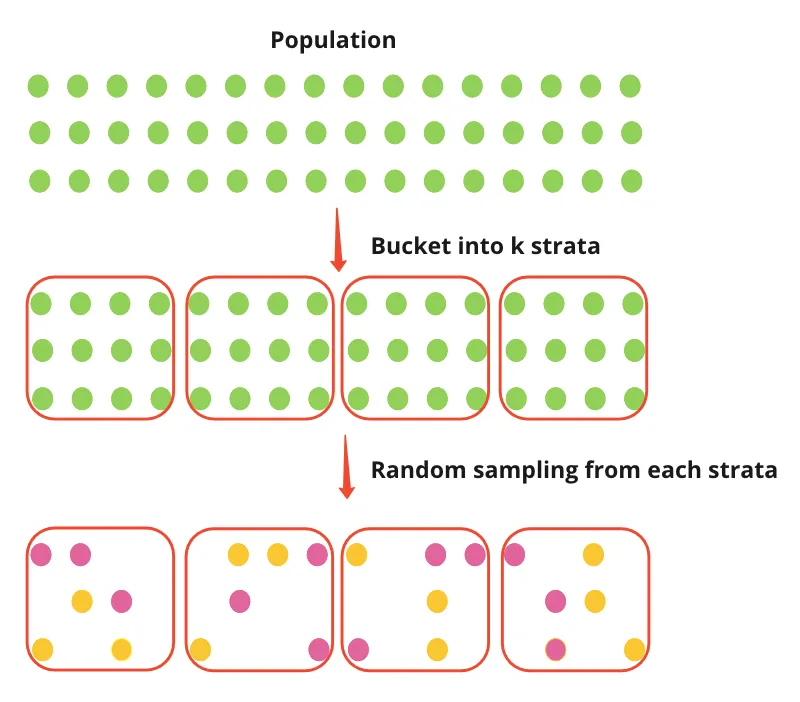

In [ ]:
strat_config = StratifiedABConfig()

# Расчет требуемого объема выборки
t_alpha = stats.norm.ppf(1 - strat_config.alpha / 2, loc=0, scale=1)
t_beta = stats.norm.ppf(1 - strat_config.beta, loc=0, scale=1)
var = 2 * strat_config.std ** 2
sample_size_calc = int((t_alpha + t_beta) ** 2 * var / (strat_config.effect ** 2))
print(f"Расчетный объем выборки: {sample_size_calc}\n")

user_ids = np.arange(strat_config.population_size)
control_user_ids, pilot_user_ids = np.random.choice(user_ids, (2, sample_size_calc), replace=False)

alpha = strat_config.alpha
N = strat_config.population_size
w_one, w_two = strat_config.w_one, strat_config.w_two
N_one = int(N * w_one)
N_two = int(N * w_two)
mu_one, mu_two = strat_config.mu_one, strat_config.mu_two
std_one, std_two = strat_config.std_one, strat_config.std_two

strats = [1 for _ in range(N_one)] + [2 for _ in range(N_two)]

sample_size = strat_config.sample_size
sample_size_one = int(sample_size * w_one)
sample_size_two = int(sample_size * w_two)

strat_to_param = {
    1: (sample_size_one, mu_one, std_one),
    2: (sample_size_two, mu_two, std_two),
}

# A/A для ошибки I рода
random_first_type_errors = []
stratified_first_type_errors = []
random_deltas = []
stratified_deltas = []

for _ in tqdm(range(3_000), desc="Замер ошибки I рода"):
    control_random, pilot_random = get_random_data(strats, sample_size, strat_to_param)
    control_stratified, pilot_stratified = get_stratified_data(strat_to_param)
    random_deltas.append(pilot_random['value'].mean() - control_random['value'].mean())
    stratified_deltas.append(pilot_stratified['value'].mean() - control_stratified['value'].mean())

    pvalue_random = ttest(control_random, pilot_random)
    random_first_type_errors.append(pvalue_random < alpha)
    pvalue_stratified = ttest(control_stratified, pilot_stratified)
    stratified_first_type_errors.append(pvalue_stratified < alpha)

part_random_first_type_errors = np.mean(random_first_type_errors)
part_stratified_first_type_errors = np.mean(stratified_first_type_errors)
print(f"{'-'*50}\nОшибка I рода без стратификации: {part_random_first_type_errors:0.3f}")
print(f"Ошибка I рода со стратификацией: {part_stratified_first_type_errors:0.3f}\n")

# A/B для ошибки II рода
effect = strat_config.effect
random_second_type_errors = []
stratified_second_type_errors = []

for _ in tqdm(range(3_000), desc="Замер ошибки II рода"):
    control_random, pilot_random = get_random_data(strats, sample_size, strat_to_param, effect)
    control_stratified, pilot_stratified = get_stratified_data(strat_to_param, effect)
    pvalue_random = ttest(control_random, pilot_random)
    random_second_type_errors.append(pvalue_random >= alpha)
    pvalue_stratified = ttest(control_stratified, pilot_stratified)
    stratified_second_type_errors.append(pvalue_stratified >= alpha)

part_random_second_type_errors = np.mean(random_second_type_errors)
part_stratified_second_type_errors = np.mean(stratified_second_type_errors)
print(f"{'-'*50}\nОшибка II рода без стратификации: {part_random_second_type_errors:0.3f}")
print(f"Ошибка II рода со стратификацией: {part_stratified_second_type_errors:0.3f}")

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.set_palette("husl")

sns.kdeplot(data=random_deltas, label="Случайное разбиение", linewidth=2.5, alpha=0.7, fill=True, color='lightgreen')
sns.kdeplot(data=stratified_deltas, label="Стратификация", linewidth=2.5, alpha=0.7, fill=True, color='lightblue')

plt.title("Распределение оценок эффекта", pad=20, fontsize=16, fontweight='bold')
plt.xlabel("Эффект", fontsize=12)
plt.ylabel("Плотность", fontsize=12)
plt.axvline(0, color='black', linestyle='--', alpha=0.5, label="Нулевой эффект")

plt.legend(title="Тип выборки", title_fontsize=12, fontsize=11, frameon=True, framealpha=0.9, facecolor='white')
plt.grid(True, alpha=0.3)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


Стратифицированное семплирование позволило уменьшить вероятности ошибок I и II рода, это очень хорошо. Но мы получили не совсем тот тест, который хотели изначально. Мы хотели проверять гипотезы на уровне значимости 0.05, а получается что проверяем на более низком уровне значимости. Так происходит из-за того, что при стратифицированном семплировании мы не только делаем распределение средних более узким, но и снижаем дисперсию, зафиксировав количество страт в каждой группе. Тест Стьюдента не знает о том, что мы семплируем данные не случайно, поэтому при подсчёте статистики используется завышенная оценка дисперсии. Вернуть тест на нужный уровень значимости нам поможет стратифицированное среднее.

Оно вычисляется как взвешенная сумма средних каждой страты, где веса – это доли страт в популяции.

Пусть $Y$ — целевая метрика, $k$ — индекс страты, $w_k$ — доля страты $k$ в популяции, $\bar{Y}_k$ — выборочное среднее метрики в страте $k$.
Тогда стратифицированное среднее $\bar{Y}_{strat}$ можно записать так:

$$
\bar{Y}_{strat} = \sum_{k=1}^K w_k \bar{Y}_k
$$

Обратим внимание на два свойства стратифицированного среднего.

* Во-первых, при стратифицированном семплировании оценка стратифицированного среднего равна оценке выборочного среднего.

$$
\bar{Y}_{strat} = \sum_{k=1}^K w_k \bar{Y}_k = \sum_{k=1}^K w_k \frac{1}{n_k} \sum_{j=1}^{n_{k}} Y_{kj} = \sum_{k=1}^K \frac{n_k}{n} \frac{1}{n_k} \sum_{j=1}^{n_{k}} Y_{kj} = \frac{1}{n} \sum_{k=1}^K \sum_{j=1}^{n_{k}} Y_{kj} = \bar{Y}
$$

* Во-вторых, при случайном семплировании математическое ожидание оценки стратифицированного среднего равно математическому ожиданию оценки обычного среднего. Более того, эти оценки являются несмещенными.

$$
\mathbb{E}_{rand}(\bar{Y}) = \mathbb{E}_{rand}( \frac{1}{n} \sum_{k=1}^K \sum_{j=1}^{n_{k}} Y_{kj}) = \frac{1}{n} \sum_{k=1}^K \sum_{j=1}^{n_{k}} \mathbb{E}_{rand} (Y_{kj}) = \frac{1}{n} \sum_{k=1}^K \sum_{j=1}^{n_{k}} \mu = \mu
$$


$$
\mathbb{E}_{strat}(\hat{Y}_{strat}) = \sum_{k=1}^K w_k \mathbb{E}_{strat}(\bar{Y}_{k}) = \sum_{k=1}^K w_k \mu_{k} = \mu
$$

**Дисперсия** оценки стратифицированного среднего вычисляется по формуле:

$$
\mathbb{V}(\bar{Y}_{strat}) \approx \frac{1}{n} \sum_{k=1}^K w_k \hat{\sigma}_k^2
$$

Эту оценку нужно использовать для вычисления статистики теста:

$$
t = \frac{\hat{Y}_{strat, B} - \hat{Y}_{strat, A}}{\sqrt{\hat{\sigma}^2_{A} + \hat{\sigma}^2_{B}}} \sim Student(\nu)
$$

In [ ]:
weights = pd.Series({1: w_one, 2: w_two})

first_type_errors = []
second_type_errors = []

for _ in tqdm(range(3_000), desc="Стратификация с весами"):
    control_aa, pilot_aa = get_stratified_data(strat_to_param)
    control_ab, pilot_ab = get_stratified_data(strat_to_param, effect)

    pvalue_aa = ttest_strat(control_aa, pilot_aa, weights)
    first_type_errors.append(pvalue_aa < alpha)
    pvalue_ab = ttest_strat(control_ab, pilot_ab, weights)
    second_type_errors.append(pvalue_ab >= alpha)

part_first_type_errors = np.mean(first_type_errors)
part_second_type_errors = np.mean(second_type_errors)
print(f"{'-'*50}\nОшибка I рода: {part_first_type_errors:0.3f}")
print(f"Ошибка II рода: {part_second_type_errors:0.3f}")


Под стратификацией обычно подразумевают одновременное применение и стратифицированного семплирования для формирования групп, и стратифицированного среднего для оценки среднего выборок. То есть в последнем численном эксперименте мы воспользовались стратификацией. Бывают ситуации, когда нет возможности провести стратифицированное семплирование, но оказывается, что в этом случае все еще можно использовать стратифицированное среднее для получения оценки. Такой подход называют постстратификацией.

######  **Постстратификация**

**Постстратификация** – это подход, при котором группы формируются случайным образом (без предварительного балансирования по стратам), но для оценки среднего значения метрики используется **стратифицированное среднее**.

На практике постстратификация применяется гораздо чаще, чем стратификация, так как ещё проще реализовать; при этом разница в эффекте будет приблизительна одинакова:

$$
\mathbb{V}_{strat}(\hat{Y}_{strat}) = \mathbb{V}_{post}(\hat{Y}_{strat}) + O \left( \frac{1}{n^2}\right) = \mathbb{V}_{rand}(\bar{Y}) + O \left( \frac{1}{n}\right)
$$

$$
\mathbb{V}_{strat}(\hat{Y}_{strat}) \le  \mathbb{V}_{post}(\hat{Y}_{strat}) \le \mathbb{V}_{rand}(\bar{Y})
$$

<br></br>

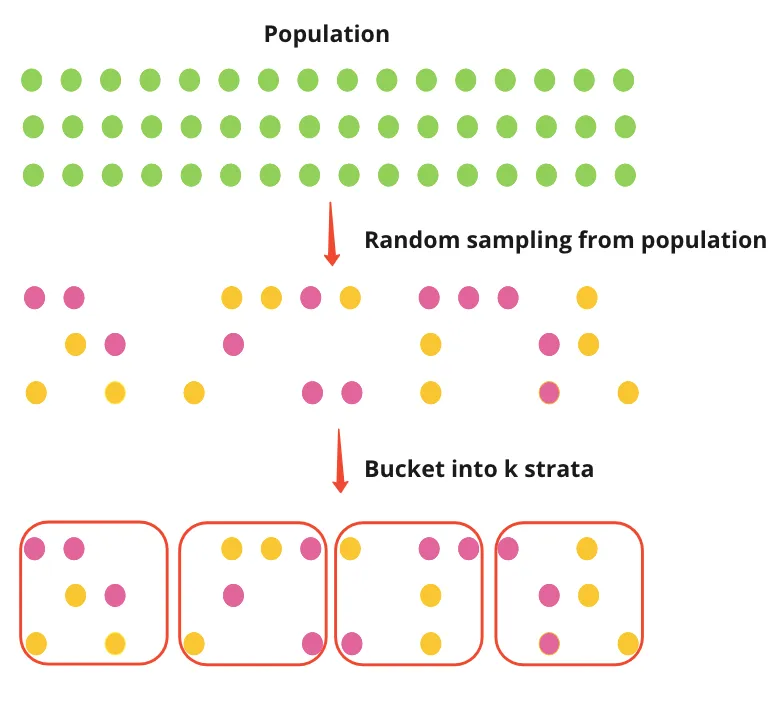

In [ ]:
first_type_errors = []
second_type_errors = []

for _ in tqdm(range(10_000), desc="Случайные страты + веса"):
    control_aa, pilot_aa = get_random_data(strats, sample_size, strat_to_param)
    control_ab, pilot_ab = get_random_data(strats, sample_size, strat_to_param, effect)

    pvalue_aa = ttest_strat(control_aa, pilot_aa, weights)
    first_type_errors.append(pvalue_aa < alpha)
    pvalue_ab = ttest_strat(control_ab, pilot_ab, weights)
    second_type_errors.append(pvalue_ab >= alpha)

part_first_type_errors = np.mean(first_type_errors)
part_second_type_errors = np.mean(second_type_errors)
print(f"{'-'*50}\nОшибка I рода: {part_first_type_errors:0.3f}")
print(f"Ошибка II рода: {part_second_type_errors:0.3f}")


##### [Бакетизация](https://habr.com/ru/articles/815331/)

**Бакетизация** — это процесс разделения общей выборки случайным образом на несколько подгрупп (buckets), которые затем анализируются отдельно. Этот метод широко используется в статистических исследованиях, особенно в A/B тестировании, в основном чтобы ускорить вычисления.

**Процесс бакетизации**
1. Определяем каждому из $N$ изначальных независимых наблюдений случайное число от 1 до $M$ ($M \le N$), назовем это бакетом.

2. Агрегируем по этим бакетам, считаем сумму метрики и количество наблюдений в каждом бакете.
3. Теперь у нас бакет является независимым наблюдением, над ним и надо проводить расчёт

In [ ]:
BUCKET_SIMULATION_CONFIG = {
    "n_buckets": 1_000,
    "n_simulations": 100,
}


def run_simulation(control_group: np.ndarray, treatment_group: np.ndarray) -> float:
    """Выполняет t-тест и возвращает p-value."""
    _, p_value = ttest_ind(control_group, treatment_group)
    return float(p_value)


def run(n_obs: int, n_buckets: int, n_simulations: int) -> Dict[str, float]:
    """Сравнивает время симуляций для сырых и агрегированных данных."""
    data_ind = np.random.normal(10, 1, n_obs)

    bucket_indices_control = np.random.randint(0, n_buckets, data_ind.size)
    bucket_sums_control = np.bincount(bucket_indices_control, weights=data_ind, minlength=n_buckets)
    bucket_counts_control = np.bincount(bucket_indices_control, minlength=n_buckets)
    data_agg = bucket_sums_control / bucket_counts_control

    params = [
        ("ind", data_ind[: n_obs // 2], data_ind[n_obs // 2 :]),
        ("agg", data_agg[: n_buckets // 2], data_agg[n_buckets // 2 :]),
    ]

    times: Dict[str, float] = {}
    for kind, left, right in params:
        start_time = time.time()
        for _ in range(n_simulations):
            run_simulation(left, right)
        elapsed_time = time.time() - start_time
        sim_type = "Individual Data" if kind == "ind" else "Aggregated Data"
        times[sim_type] = elapsed_time
    return times


ns_obs = np.linspace(10**4, 10**7, 100).astype(int)
results: Dict[int, Dict[str, float]] = {}
for n_obs in tqdm(ns_obs, desc="Processing user counts"):
    results[n_obs] = run(n_obs, BUCKET_SIMULATION_CONFIG["n_buckets"], BUCKET_SIMULATION_CONFIG["n_simulations"])

ind_times = np.asarray([results[n]["Individual Data"] for n in ns_obs])
agg_times = np.asarray([results[n]["Aggregated Data"] for n in ns_obs])
ratio = ind_times / agg_times

slope, intercept, r_value, p_value, std_err = stats.linregress(ns_obs, ratio)
trendline = intercept + slope * ns_obs

fig = go.Figure()
fig.add_trace(go.Scatter(x=ns_obs, y=ratio, mode="markers+lines", name="Data Points"))
fig.add_trace(
    go.Scatter(
        x=ns_obs,
        y=trendline,
        mode="lines",
        name="Trend Line",
        line=dict(color="red", dash="dash"),
    )
)

stats_text = f"Slope: {slope:.2e}<br>Intercept: {intercept:.2f}<br>R-squared: {r_value**2:.3f}"
fig.add_annotation(
    x=ns_obs[-1],
    y=trendline[-1],
    text=stats_text,
    showarrow=True,
    font=dict(size=12),
    arrowhead=1,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor="red",
    ax=20,
    ay=-30,
    bgcolor="white",
    bordercolor="black",
)

fig.update_layout(
    title="Comparison of Computation Times",
    xaxis_title="Number of Users",
    yaxis_title="Individual approach time / Aggregated approach time",
    plot_bgcolor="white",
    paper_bgcolor="white",
    font_color="black",
    width=1200,
    height=800,
    showlegend=True,
)

fig.show()


Тем не менее, из бакетизации можно попытаться выжать не только прибавку к скорости, если особым образом выбрать алгоритм определения бакеты:
1. можно делить по децилям и проводить [децильный анализ](https://vk.com/@sciensespss-decilnyi-metod-ili-sokraschenie-dispersii)
2. можно назначать бакеты согласно каким-то ковариатам, которые не изменяются в процессе эксперимента (то есть нулевая корреляция эффекта и ковариаты) и имеют высокую коварицию с метрикой ~ стратификация (CUPED)

##### [Линеаризация](https://www.researchgate.net/publication/322969314_Consistent_Transformation_of_Ratio_Metrics_for_Efficient_Online_Controlled_Experiments)

**Линеаризация метрик** — это преобразование, которое применяется к **метрикам отношения** (ratio metrics) с целью превращения их в **аддитивные пользовательские метрики**. Иными словами, мы создаем новую метрику для каждого пользователя, которая уже не является отношением, но сохраняет информацию об изменениях в исходной метрике.

Классические метрики отношения часто обладают высокой дисперсией и могут иметь "тяжелые хвосты" или быть ограничены в диапазоне (например, от 0 до 1), что усложняет обнаружение статистически значимых изменений. Линеаризация **снижает дисперсию** преобразованной метрики, делая её распределение более "сжатым" и предсказуемым, что "растягивает" её диапазон и повышает чувствительность к различиям. Это можно сравнить с логарифмическим преобразованием в машинном обучении, которое улучшает качество моделей за счет нормализации распределения целевой переменной.

Для метрики отношения, которая на пользовательском уровне может быть представлена как $\mathcal{R} = \frac{\sum_{u \in U} Y(u)}{\sum_{u \in U} X(u)}$, линеаризованная метрика будет выглядеть как
$$
Lin(u) = Y(u) - \mathcal{R}^{ctrl} X(u) \text{ , где } \mathcal{R}^{ctrl} - \text{значение метрики отношения в контрольной группе}
$$

После того, как мы посчитали линеаризованую метрику для каждого пользователя, можно использовать классические статистические тесты для проверки гипотез, либо же вернуться к метрике отношения $Lin = \frac{\sum_{u}Lin(u)}{|U|}$ и считать с помощью delta-метода статистику. Но в таком случае мы теряем часть информации об активности пользователей (когда просто делим на общее количество), из-за чего необходимо делать перевзвешивание. Например, можно сначала взвесить метрику на корень знаменателя, а потом линеаризовать:

$$
\mathcal{R}_{rew} = \frac{\sum_u \sqrt{X(u)} \times \frac{Y(u)}{X(u)}}{\sqrt{X(u)}}
$$


$$
Lin_{rew} = \frac{\sum_u \sqrt{X(u)} \times (Y(u) - \mathcal{R}_{rew}^{ctrl} X(u))}{\sqrt{X(u)}}
$$

In [ ]:
@dataclass
class RatioConfig:
    n_users: int = 10_000
    n_simulations: int = 5_000
    alpha: float = 0.05
    seed: int = 42
    sigma_noise: float = 0.5


def generate_ab_data(n: int, delta: float, sigma: float) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Генерирует синтетические данные для A/B с мультипликативным шумом."""
    grp = np.array([0] * n + [1] * n)
    x_values = np.random.gamma(2, 1, 2 * n)
    eps = np.random.normal(0, sigma, 2 * n)
    y_values = x_values * (1 + delta * (grp == 1)) + eps
    return grp, x_values, y_values


def simulate_fpr(config: RatioConfig) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Оценивает уровень ошибки I рода для разных нормировок метрики."""
    np.random.seed(config.seed)
    p_naive = np.empty(config.n_simulations)
    p_lin = np.empty(config.n_simulations)
    p_wlin = np.empty(config.n_simulations)

    for i in tqdm(range(config.n_simulations), desc="A/A FPR"):
        grp, X, Y = generate_ab_data(config.n_users, 0.0, config.sigma_noise)

        r0 = Y[grp == 0] / X[grp == 0]
        r1 = Y[grp == 1] / X[grp == 1]
        p_naive[i] = stats.ttest_ind(r1, r0, equal_var=False).pvalue

        R0 = Y[grp == 0].sum() / X[grp == 0].sum()
        lin = Y - R0 * X
        p_lin[i] = stats.ttest_ind(lin[grp == 1], lin[grp == 0], equal_var=True).pvalue

        r = Y / X
        w = np.sqrt(X)
        Rw = (w[grp == 0] * r[grp == 0]).sum() / w[grp == 0].sum()
        linw = w * (r - Rw)
        p_wlin[i] = stats.ttest_ind(linw[grp == 1], linw[grp == 0], equal_var=True).pvalue

    return p_naive, p_lin, p_wlin


def simulate_ab_effects(config: RatioConfig, delta: float) -> tuple[dict[str, np.ndarray], dict[str, np.ndarray]]:
    """Моделирует оценку эффекта и ширину доверительных интервалов."""
    np.random.seed(config.seed + 1)
    ests = {"naive": [], "lin": [], "wlin": []}
    cis = {"naive": [], "lin": [], "wlin": []}

    for _ in tqdm(range(config.n_simulations), desc="A/B absolute"):
        grp, X, Y = generate_ab_data(config.n_users, delta, config.sigma_noise)
        n = config.n_users

        Y0 = Y[grp == 0]
        Y1 = Y[grp == 1]
        d0 = Y1.mean() - Y0.mean()
        se0 = np.sqrt(Y1.var(ddof=1) / n + Y0.var(ddof=1) / n)
        ci0 = 1.96 * se0

        R0 = Y0.sum() / X[grp == 0].sum()
        resid = Y - R0 * X
        r0 = resid[grp == 0]
        r1 = resid[grp == 1]
        d1 = r1.mean() - r0.mean()
        se1 = np.sqrt(r1.var(ddof=1) / n + r0.var(ddof=1) / n)
        ci1 = 1.96 * se1

        w = np.sqrt(X)
        Rw = (w[grp == 0] * Y[grp == 0]).sum() / (w[grp == 0] * X[grp == 0]).sum()
        resid_w = Y - Rw * X
        rw0 = resid_w[grp == 0]
        rw1 = resid_w[grp == 1]
        d2 = rw1.mean() - rw0.mean()
        se2 = np.sqrt(rw1.var(ddof=1) / n + rw0.var(ddof=1) / n)
        ci2 = 1.96 * se2

        ests["naive"].append(d0)
        ests["lin"].append(d1)
        ests["wlin"].append(d2)
        cis["naive"].append(ci0)
        cis["lin"].append(ci1)
        cis["wlin"].append(ci2)

    for k in ests:
        ests[k] = np.array(ests[k])
        cis[k] = np.array(cis[k])
    return ests, cis


def plot_ab_absolute(ests: Dict[str, np.ndarray], cis: Dict[str, np.ndarray], delta: float, config: RatioConfig) -> None:
    """Рисует распределения оценок эффекта и доверительных интервалов для разных нормировок."""
    methods = ["naive", "lin", "wlin"]
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
    true_effect = delta * np.mean(generate_ab_data(10_000, 0, config.sigma_noise)[1])

    plt.figure(figsize=(10, 6), dpi=100)
    ax = plt.gca()
    ax.set_facecolor("#f5f5f5")

    boxprops = dict(linewidth=1.5, alpha=0.7)
    whiskerprops = dict(linewidth=1.5, linestyle="--")
    medianprops = dict(linewidth=2, color="firebrick")

    bp = ax.boxplot(
        [ests[m] for m in methods],
        labels=["Деление на X", "Линейная коррекция", "Взвешенная линейная"],
        patch_artist=True,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        medianprops=medianprops,
        widths=0.6,
    )

    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)

    for i, method in enumerate(methods, start=1):
        mean = ests[method].mean()
        ci_width = cis[method].mean()

        ax.plot([i - 0.3, i + 0.3], [mean, mean], color="black", linewidth=2.5, solid_capstyle="round", label="Среднее" if i == 1 else "")
        ax.vlines(i, mean - ci_width, mean + ci_width, color="black", linewidth=2, linestyle="-", label="95% ДИ" if i == 1 else "")

        ax.axhline(true_effect, color="#d62728", linewidth=2.5, linestyle="--", label="Истинный эффект")

    ax.set_title(f"Оценка эффекта при delta = {delta}", fontsize=14, pad=20)
    ax.set_ylabel("Эффект", fontsize=12)
    ax.tick_params(axis="both", which="major", labelsize=11)

    handles, labels = ax.get_legend_handles_labels()
    unique = []
    for h, l in zip(handles, labels):
        if l not in [lbl for _, lbl in unique]:
            unique.append((h, l))
    ax.legend(*zip(*unique), loc="upper right", framealpha=1)

    ax.grid(True, linestyle="--", alpha=0.7)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()


config = RatioConfig()
delta = 0.01
ests, cis = simulate_ab_effects(config, delta)
plot_ab_absolute(ests, cis, delta, config)


##### [Weighted Variance Estimator](https://www.youtube.com/watch?v=jZNXthVqbrc)

**Weighted Variance Estimator (WVE)** — это метод оценки дисперсии, который учитывает гетероскедастичность данных (непостоянство дисперсии) через присвоение каждому наблюдению веса, обратно пропорционального его дисперсии. Цель состоит в том, чтобы получить новую метрику или оценить эффект таким образом, чтобы дисперсия оценки была минимизирована.


$$
\mathbb{V}(\hat{\mu}) = \frac{\sum_i w_i^2 \sigma_i^2}{\left( \sum_i w_i \right)^2}
$$

In [ ]:
def simulate_wve_vs_classical(n_simulations: int = 1000, n_samples: int = 100) -> dict[str, List[float]]:
    """Сравнивает классический средний и WVE при гетероскедастичности."""
    true_mean = 5.0

    X = np.linspace(1, 10, n_samples)
    sigma = 0.5 * X

    results: dict[str, List[float]] = {
        "Classical": [],
        "WVE": [],
        "Classical_SE": [],
        "WVE_SE": [],
    }

    for _ in range(n_simulations):
        noise = np.random.normal(0, sigma)
        Y = true_mean + noise

        classical_mean = float(np.mean(Y))
        classical_se = float(np.std(Y) / np.sqrt(n_samples))
        results["Classical"].append(classical_mean)
        results["Classical_SE"].append(classical_se)

        weights = 1 / (sigma ** 2)
        wve_mean = float(np.sum(weights * Y) / np.sum(weights))
        wve_se = float(1 / np.sqrt(np.sum(weights)))
        results["WVE"].append(wve_mean)
        results["WVE_SE"].append(wve_se)

    return results


results = simulate_wve_vs_classical(n_simulations=5_000, n_samples=200)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.boxplot(data=[results['Classical'], results['WVE']])
plt.xticks([0, 1], ['Классическое среднее', 'WVE среднее'])
plt.ylabel('Оценка среднего')
plt.grid(True)
plt.axhline(y=5.0, color='r', linestyle='--', alpha=0.7, label='Истинное среднее')
plt.legend()
plt.title('Сравнение оценок средних')

plt.subplot(1, 2, 2)
sns.kdeplot(results['Classical'], label='Classical Mean', fill=True)
sns.kdeplot(results['WVE'], label='WVE Mean', fill=True)
plt.axvline(x=5.0, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Оценка среднего')
plt.ylabel('Плотность')
plt.title('Распределение оценок')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


##### [CUPED](https://habr.com/ru/companies/X5Tech/articles/780270/)

**CUPED (Controlled-experiment Using Pre-Experiment Data)** — это высокоэффективный метод, предназначенный для уменьшения дисперсии метрик в A/B-тестах за счет ковариатной корректировки. Его основная идея заключается в том, чтобы "вычесть что-то из теста и из контроля таким образом, чтобы математическое ожидание разницы новых величин осталось прежним, а дисперсия уменьшилась"

<br></br>

Ковариата — это метрика, скоррелированная с метрикой эксперимента, которая не зависит от эксперимента. В качестве ковариаты часто берут значения метрики эксперимента, посчитанные на периоде до эксперимента. Обозначим значения метрики эксперимента как $Y$, а значения ковариаты как $X$.

Суть метода CUPED состоит в переходе от метрики $Y$ к метрике $Y_{cuped}$, которая вычисляется по формуле:
$$
Y_{cuped} = Y - \theta X \text{, где } \theta — \text{некоторое действительное число}
$$

Для каждого объекта в контрольной и экспериментальной группе нужно получить значения целевой метрики и ковариаты, и по ним для каждого объекта вычислить значение новой CUPED-метрики. Значения CUPED-метрики контрольной и экспериментальной групп будут подаваться в статистический критерий для проверки гипотезы.

Точечная оценка эффекта вычисляется как разница средних значений метрики в контрольной и экспериментальной группах. Если пользователи по группам распределяются случайно, и ковариата не зависит от эксперимента, то при замене исходной метрики на CUPED-метрику точечная оценка эффекта будет несмещённой.

Чем меньше дисперсия, тем больше чувствительность теста. Посмотрим, как меняется дисперсия оценки среднего при переходе к CUPED-метрике:
$$
\mathbb{V}(\overline{Y}_{cuped}) = \mathbb{V}\left(\overline{Y} - \theta \overline{X}\right) = \dfrac{\mathbb{V}\left(Y - \theta X\right)}{n} = \dfrac{\mathbb{V} (Y) - 2\theta\mathrm{cov}\left(Y,X\right) + \theta^2\mathbb{V} (X)}{n}
$$

Дисперсия зависит от $\theta$ квадратично. Это простая парабола с точкой минимума $\theta_0 = \frac{\mathrm{cov}(Y,X)}{\mathbb{V} (X)}$

Минимальная дисперсия равна:
$$
\min\left(\mathbb{V} (\overline{Y}_{cuped})\right) = \mathbb{V} (\overline{Y}) \cdot \left(1 - \rho^2\right), \qquad где \ \rho = \frac{\mathrm{cov}(Y,X)} {\sqrt{\mathbb{V} (Y) \mathbb{V} (X)}}
$$
Чем сильнее ковариата коррелирует с целевой метрикой, тем сильнее с помощью CUPED можно снизить дисперсию.

**Алгоритм применения CUPED**

1. вычислить значения исходной метрики $Y$ для каждого пользователя в контрольной и экспериментальной группах;

2. вычислить значения ковариаты $X$ для каждого пользователя в контрольной и экспериментальной группах;

3. вычислить параметр $\theta$ по формуле $\theta = \frac{\mathrm{cov}(Y,X)}{\mathbb{V} (X)}$;

4. для каждого пользователя вычислить CUPED-метрику по формуле $Y_{cuped} = Y - \theta X$;

5. применить статистический тест на значениях CUPED-метрики контрольной и экспериментальной групп.

**Примечание**

В таком виде оценка $Y_{cuped}$ является состоятельной, но несмещённой. Чтобы она не имела систематической разницы необходимо также делать поправку на среднее ковариаты: $Y_{cuped} = Y - \theta (X - \bar{X})$.

$$
\mathbb{E}(Y_{cuped}) = \mathbb{E}(Y) - \theta \mathbb{E}(X) + \theta \mathbb{E}(\bar{X}) = \mathbb{E}(Y)
$$

###### Симуляция

In [ ]:
def generate_data(sample_size: int, corr: float, mean: float = 2000, sigma: float = 300) -> pd.DataFrame:
    """Генерирует двумерные данные метрика/ковариата с заданной корреляцией."""
    means = np.array([mean, mean])
    cov = sigma ** 2 * np.array([[1, corr], [corr, 1]])
    data = np.random.multivariate_normal(means, cov, sample_size).astype(int)
    df = pd.DataFrame({'metric': data[:, 0], 'covariate': data[:, 1]})
    return df


def calculate_theta(metrics: Iterable[float], covariates: Iterable[float]) -> float:
    """Считает коэффициент theta для CUPED."""
    covariance = np.cov(covariates, metrics)[0, 1]
    variance = np.var(covariates)
    theta = covariance / variance
    return float(theta)


def check_ttest(df_control: pd.DataFrame, df_pilot: pd.DataFrame) -> float:
    """Возвращает p-value t-теста для исходных метрик."""
    values_control = df_control['metric'].values
    values_pilot = df_pilot['metric'].values
    _, pvalue = stats.ttest_ind(values_control, values_pilot)
    return float(pvalue)


def check_cuped(df_control: pd.DataFrame, df_pilot: pd.DataFrame, df_theta: pd.DataFrame) -> float:
    """Возвращает p-value t-теста после CUPED-коррекции."""
    theta = calculate_theta(df_theta['metric'], df_theta['covariate'])
    metric_cuped_control = df_control['metric'] - theta * df_control['covariate']
    metric_cuped_pilot = df_pilot['metric'] - theta * df_pilot['covariate']
    _, pvalue = stats.ttest_ind(metric_cuped_control, metric_cuped_pilot)
    return float(pvalue)


def plot_pvalue_distribution(dict_pvalues: Dict[str, List[float]], alpha: float = 0.05, figsize: Tuple[int, int] = (10, 7)) -> None:
    """Строит распределение накопленных p-value по разным методам."""
    sns.set_style("whitegrid")
    plt.figure(figsize=figsize)
    colors = plt.cm.tab10(np.linspace(0, 1, len(dict_pvalues)))

    for i, (key, pvalues) in enumerate(dict_pvalues.items()):
        sorted_p = np.sort(pvalues)
        y = np.arange(1, len(sorted_p) + 1) / len(sorted_p)
        plt.plot(sorted_p, y, lw=2.5, color=colors[i], alpha=0.9, label=f'{key} (n={len(pvalues)})')
        rejected = sorted_p <= alpha
        if np.any(rejected):
            plt.fill_between(sorted_p[rejected], 0, y[rejected], color=colors[i], alpha=0.15)

    x = np.linspace(0, 1, 500)
    plt.plot(x, x, '--k', lw=2, alpha=0.7, label='Равномерное распределение H0')
    plt.axvline(x=alpha, color='r', linestyle=':', lw=2, alpha=0.8)
    plt.text(alpha + 0.01, 0.05, f'α = {alpha}', fontsize=12, color='r', ha='left')

    plt.title('Распределение p-values', fontsize=16, pad=15)
    plt.xlabel('p-value', fontsize=13)
    plt.ylabel('Доля наблюдений', fontsize=13)
    plt.legend(loc='lower right', fontsize=11, frameon=True, framealpha=0.9)

    ax2 = plt.gca().twinx()
    ax2.set_ylim(0, 1)
    ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax2.set_ylabel('Кумулятивная доля', fontsize=13)

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
sample_size = 1000
corr = 0.7
effect = 20
dict_pvalues = defaultdict(list)

for _ in tqdm(range(1000)):
    df_control = generate_data(sample_size, corr)
    df_pilot = generate_data(sample_size, corr)
    df_theta = pd.concat([df_control, df_pilot])
    dict_pvalues['cuped A/A'].append(check_cuped(df_control, df_pilot, df_theta))
    df_pilot['metric'] += effect
    df_theta = pd.concat([df_control, df_pilot])
    dict_pvalues['cuped A/B'].append(check_cuped(df_control, df_pilot, df_theta))
    dict_pvalues['ttest A/B'].append(check_ttest(df_control, df_pilot))

plot_pvalue_distribution(dict_pvalues)

###### Как выбирать $\theta$

**Какую ковариату выбрать**

Самое сложно в использовании CUPED — это выбор ковариаты. От ковариаты зависит, насколько чувствительнее станет критерий. Можно придумать огромное количество вариантов ковариат. Обсудим некоторые из них.

Скоррелированность влияет на уменьшение дисперсии. Чем сильнее ковариата коррелирует с метрикой, тем сильнее уменьшается дисперсия. Независимость важна, так как иначе критерий может стать некорректным. Например, если взять в качестве ковариаты саму метрику во время эксперимента, то все значения CUPED-метрики в обеих группах будут равны одному и тому же значению, критерий всегда будет говорить, что значимых отличий нет.

В качестве ковариаты часто берут значения метрики эксперимента, посчитанные на периоде до эксперимента. Корреляция ковариаты с метрикой обусловлена сохраняющимся поведением исследуемых объектов в течение времени. Проводимый эксперимент не влияет на события случившиеся до его начала, поэтому такая ковариата не зависит от эксперимента. Главное преимущество этой ковариаты – в её простоте. Легко посчитать, сложно ошибиться.

Чтобы сильнее снизить дисперсию, можно поэкспериментировать с продолжительностью периода для вычисления ковариаты. Например, проверяем гипотезу об изменении средней выручки с покупателя. Если эксперимент идёт неделю, то можно в качестве ковариаты использовать как выручку с пользователя за неделю до эксперимента, так и выручку с пользователя за 4 или 8 недель до эксперимента. Такой подход работает лучше для редких событий, когда пользователи покупают в среднем реже одного раза в неделю.

Если в поведении исследуемых объектов есть сезонность, попробуйте использовать значение метрики в аналогичный период прошлого сезона.

Можно использовать данные, полученные во время эксперимента, если наше воздействие на них не влияет. Например, это могут быть данные о погоде, если эксперимент не изменяет климат и не приводит к погодным аномалиям.

**За какой период считать $\theta$**

Базово приходит 4 идеи:
1. на объединённых данных контрольной и экспериментальной групп
2. на данных контрольной группы
3. на данных экспериментальной группы
4. на исторических данных

Если кратко, то
* Если размеры групп велики и эксперимент не приводит к сильному изменению корреляции ковариаты с целевой метрикой, то все предложенные способы оценки $\theta$ дадут одинаковые результаты.
* Если размеры групп достаточно велики, лучше оценивать $\theta$ на объединённых данных контрольной и экспериментальной групп.
* Если размеры групп малы, то оценка $\theta$ на исторических данных может дать лучшее качество.

В любом случае лучше всегда проверять корреляцию на A/A тестах, чтобы выбрать оптимальный вариант. [Здесь](https://habr.com/ru/companies/X5Tech/articles/780270/#:~:text=%D0%9D%D0%B0%20%D1%87%D1%91%D0%BC%20%D0%BE%D1%86%D0%B5%D0%BD%D0%B8%D0%B2%D0%B0%D1%82%D1%8C%20Theta) приводятся симуляции разных исходов, откуда и были выведена тезисы сверху

##### [Predictive CUPED](https://www.youtube.com/watch?v=jPysoXa3udU&t=7s)

**Предиктивный CUPED** крайне похож на обычный **CUPED**, т.к. так же полагается на использование ковариат для очистки целевой метрики от шума, делая дисперсию оценки меньше.


**Алгоритм**

1. вычислить значения исходной метрики $Y$ для каждого пользователя в контрольной ($Y^c$) и экспериментальной ($Y^t$) группах;

2. вычислить значения ковариаты $X$ для каждого пользователя в контрольной ($X^c$) и экспериментальной ($X^t$) группах;

3. вычислить параметр $\theta^c$ по формуле $\theta^c = \frac{\mathrm{cov}(Y^c,X^c)}{\mathbb{V} (X^c)}$;

4. для каждого пользователя контрольной группы регрессией вычислить оценку целевой метрики: $\hat{Y^c} = \theta^c X^c$


4. для каждого пользователя тестовой группы регрессией вычислить оценку целевой метрики: $\hat{Y^t} = \theta^c X^t$

5. посчитать очищенные метрики для контрольной и тестовой группы:
$$
Y^t_{resid} =Y^t - \hat{Y}^t \\
Y^c_{resid} =Y^c - \hat{Y}^c
$$

6. применить статистический тест на значениях очищенных метрик контрольной и экспериментальной групп.

Такая оценка получается несмещённой и состоятельной, но при этом
1. оценка является более мощной, чем обычный CUPED;
2. дисперсия оценки больше, чем получается CUPED, т.к. модель обучается только на части данных;

##### [CUPAC](https://careersatdoordash.com/blog/improving-experimental-power-through-control-using-predictions-as-covariate-cupac/)

**CUPAC (Control Using Predictions As Covariates)** является ещё одним расширением обычного CUPED, только он предполагает не использование какой-то готовой ковариаты, а непосредственное предсказанное значение целевой переменной с помощью какого-либо алгоритма машинного обучения. Цель модели машинного обучения - создать предикт на основе ковариат с максимальной частичной корреляцией с целевой метрикой.

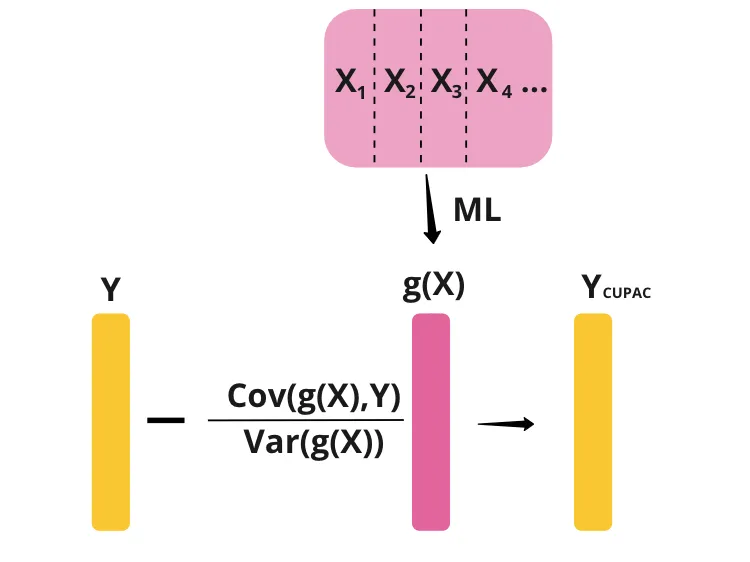


##### [MLRATE](https://arxiv.org/pdf/2106.07263)

MLRATE (machine learning regression-adjusted treatment effect estimator) был предложен Го и другими исследователями из Принстона и Facebook в 2021 году.

Подобно CUPAC, MLRATE также использует модель машинного обучения для прогнозирования $Y$ на основе $X$. Назовём прогнозируемое значение $g(X)$. Вместо вычитания $g(X)$ из $Y$, MLRATE включает $g(X)$ вместе с индикатором эффекта в регрессионную модель, а затем вычисляет эффект с поправкой на регрессию. На рисунке ниже представлена эта регрессионная модель:

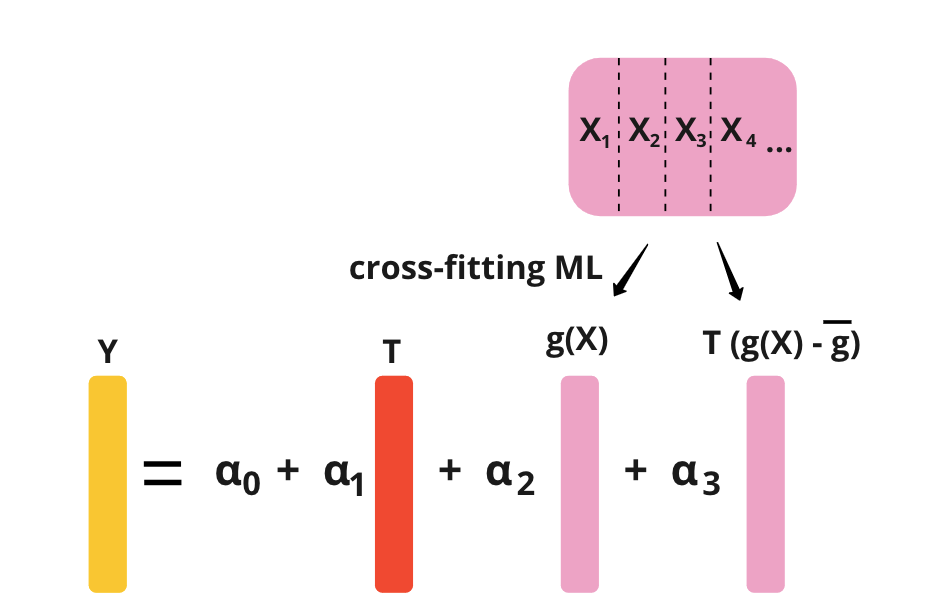

**Алгоритм**

1. Разобьём данные $(Y_i,X_i,T_i)^N_{i=1}$ равномерно случайным образом на $K$ групп, равных по размеру. Тогда $I_k :=$ индекс $k$-ой группы, а $I^c_k := \{ 1,2,\cdots, N \}$ \ $I_k$

2. Для каждой группы $k$ обучаем ML алгоритм $M$ на данных $(Y_i,X_i)_{i \in I_k^c}$ и пучаем функцию $\hat{g}_k : X_i ⟶ Y_i$

3. Считаем среднее функции $\bar{g} = \frac{1}{N} \sum_i \hat{g}_{k(i)}(X_i)$, где $k_i$ - индекс группы ,содержащей $X_i$
4. Считаем $\hat{\alpha}_1$ OLS оценкой для $\alpha_1$ в $Y_i = \alpha_0 + \alpha_1T_i + \alpha_2\hat{g}_{k(i)}(X_i) + \alpha_3T_i(\hat{g}_{k(i)}(X_i) - \bar{g}) + \epsilon_i$  


### Культура A/B-тестирования: когда процесс важнее математики ?

В мире, где каждая компания мечтает стать data-driven, A/B-тестирование превратилось в нечто большее, чем просто инструмент принятия решений. Это философия, образ мышления, культура. Но парадокс в том, что большинство организаций, зациклившись на статистических тонкостях — поправках Бонферрони, методах CUPED, стратификации — упускают из виду главное: скорость и качество тестирования определяются не только формулами, но и тем, как устроен процесс.

Можно годами оптимизировать дисперсию, внедрять передовые методы анализа, но если гипотезы неделями болтаются в почте между менеджерами, если платформа тестирования требует ручного вмешательства на каждом шаге, если команда не понимает, какие эксперименты уже запущены и как они взаимодействуют — никакая математика не спасет.

**Почему культура тестирования важнее, чем кажется**

Представьте: Data Scientist тратит три дня на расчет необходимой выборки, применяет все возможные методы сокращения дисперсии, запускает тест — и тут выясняется, что маркетинг уже проводит кампанию, которая влияет на ту же аудиторию. Или что метрика, которую все считали основной, на самом деле никем не согласована. Или что результаты теста не могут быть развернуты, потому что изменения не были заранее интегрированы в CI/CD.

Такие ситуации — не редкость. Они происходят не из-за недостатка знаний статистики, а из-за отсутствия четких процессов, стандартов и инфраструктуры.

1. **Шаблоны и стандарты: как избавиться от хаоса**

Одна из самых больших потерь времени в A/B-тестировании — не само проведение эксперимента, а его подготовка. Бесконечные уточнения: "А что именно мы тестируем?", "Какие метрики будем смотреть?", "Какой минимальный эффект нас устроит?"

Хорошая культура тестирования начинается с единого языка. Вместо долгих обсуждений в почте или чатах — четкие шаблоны. Например:
```
Гипотеза: "Мы ожидаем, что увеличение размера кнопки 'Купить' на 20% приведет к росту конверсии
в покупку на 1.5% для всех пользователей мобильного приложения, потому что текущий размер кнопки
ниже минимального рекомендуемого для удобного нажатия."

Метрики:

* Основная: конверсия в покупку (ожидаемый эффект: +1.5%, минимально значимый: +0.8%)
* Контрольная: средний чек (допустимое изменение: ±3%)
* Время проведения: 14 дней
```
Когда такие шаблоны становятся стандартом, исчезает крайне много бюрократии.

2. **Автоматизация расчета: когда отчеты генерируются сами**

Второй бич скорости тестирования — ручная подготовка отчетов. Data Scientist тратит часы на выгрузку данных, проверку аномалий, пересчет метрик. А потом оказывается, что кто-то забыл учесть новый фильтр в данных, и все нужно переделывать.

Решение — автоматизированные дашборды (расчёты), которые:

* Считают метрики в реальном времени.
* Автоматически применяют методы сокращения дисперсии, поправки на множественность тестирования.
* Показывают не только статистическую значимость, но и бизнес-значимость (например: "Эффект +1.2%, но доверительный интервал включает +0.3% — возможно, изменение не стоит внедрять").
* Отправляют уведомления, когда тест достигает достаточной мощности.

3. **A/B-платформа: конвейер для экспериментов**

Без нормальной платформы A/B-тестирование превращается в рутину. Хорошая платформа должна:
* Автоматически распределять пользователей в бакеты (с учетом слоев, чтобы тесты не пересекались).
* Интегрироваться с системой развертывания, чтобы изменения можно было включать и выключать мгновенно.
* Хранить историю всех экспериментов, чтобы избежать повторения одних и тех же тестов.
* Позволять настраивать сценарии тестов без участия разработчиков (например: "Проверить три варианта заголовка на главной странице").

Когда платформа работает как часы, команда тратит время не на настройку экспериментов, а на их анализ.

4. **Календарь тестов: как не утонуть в трафике**

Одна из самых распространенных проблем — конфликты тестов. Маркетинг запускает промо-кампанию, продуктовая команда тестирует новый дизайн, а аналитики проверяют алгоритм рекомендаций — и все на одной и той же аудитории. В итоге результаты невозможно интерпретировать.

Календарь тестов решает эту проблему. В нем указывается:
* Какие эксперименты запущены.
* На какую аудиторию они влияют.
* Когда ожидаются результаты.
* Какие метрики затрагивают.

Это позволяет планировать тесты так, чтобы они не мешали друг другу.

5. **Слои (Layering)**

Когда тестов много, а трафика мало, без слоев не обойтись. Идея проста: пользователи распределяются не только по бакетам (A/B), но и по независимым слоям. Например:

Слой 1: Изменения в ценообразовании.
Слой 2: Новый дизайн карточек товаров.
Слой 3: Разные алгоритмы рекомендаций.

Если слои ортогональны (не влияют друг на друга), можно запускать десятки тестов одновременно.

##### Заключение

Культура тестирования — это не про инструменты, а про людей. Можно купить самую продвинутую A/B-платформу, нанять лучших Data Scientist, но если в компании нет культуры, где тестирование — это не разовая акция, а часть ежедневных процессов, все усилия будут напрасны.

Культура тестирования — это когда:

* Продуктовые менеджеры формулируют гипотезы до начала разработки, а не после.
* Маркетинг согласовывает кампании с календарем тестов.
* Разработчики сразу закладывают возможность A/B-тестирования в новые фичи.
* Руководство понимает, что не все тесты дают значимый результат — и это нормально.

Когда эти принципы работают, скорость тестирования увеличивается в разы. И тогда уже можно заниматься тонкой настройкой статистических методов — потому что процесс больше не тормозит сам себя.